In [1]:
###### Package installations to work on WIRE

! pip install mamba
! pip install pysankey
! mamba install gensim openai -y
! mamba install -c anaconda nltk -y
! mamba install -c conda-forge spacy -y
! mamba install -c conda-forge pyldavis -y
! mamba install -c conda-forge pypdf2 -y
! pip install transformers sentence-transformers
! pip install scikit-network
! pip install git+https://github.com/rwalk/gsdmm.git

! python -m spacy download en_core_web_sm

  Using cached mamba-0.11.2-py3-none-any.whl
  Using cached clint-0.5.1-py3-none-any.whl
  Using cached coverage-7.2.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (227 kB)
  Using cached args-0.1.0-py3-none-any.whl
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/usr/local/bin/coverage'
Consider using the `--user` option or check the permissions.

  Using cached pySankey-0.0.1-py3-none-any.whl (4.9 kB)
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
/bin/bash: line 1: mamba: command not found
  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-jb09s1wg
  Running command git clone --filter=blob:none --quiet https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-jb09s1wg
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d35

In [1]:
# imports

import csv
import json
import os
import re
from pprint import pprint
import time
import re
import unicodedata
import os
import sys
from contextlib import contextmanager
from copy import deepcopy
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import pickle
#import sknetwork as skn
from random import *

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd


import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt", "wordnet"])
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ps = nltk.porter.PorterStemmer()

#from gsdmm import MovieGroupProcess

from sentence_transformers import SentenceTransformer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

from itertools import combinations

from scipy.spatial.distance import squareform
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering

# set seed for reproducibility
# np.random.seed(493)

[nltk_data] Downloading package names to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to C:\Users\Seth
[nltk_data]     Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Seth Benson\AppData\Roaming\nltk_data...
[nltk_data]   Package aver

In [2]:
cnn_list = ['final_processed_CNN_transcripts_llm_January2020.csv','final_processed_CNN_transcripts_llm_February2020.csv','final_processed_CNN_transcripts_llm_March2020.csv',
'final_processed_CNN_transcripts_llm_April2020.csv','final_processed_CNN_transcripts_llm_May2020.csv','final_processed_CNN_transcripts_llm_June2020.csv',
'final_processed_CNN_transcripts_llm_July2020.csv','final_processed_CNN_transcripts_llm_August2020.csv','final_processed_CNN_transcripts_llm_September2020.csv',
'final_processed_CNN_transcripts_llm_October2020.csv','final_processed_CNN_transcripts_llm_November2020.csv', 'final_processed_CNN_transcripts_llm_December2020.csv']
msnbc_list = ['final_processed_MSNBC_transcripts_llm_January2020.csv','final_processed_MSNBC_transcripts_llm_February2020.csv','final_processed_MSNBC_transcripts_llm_March2020.csv',
'final_processed_MSNBC_transcripts_llm_April2020.csv','final_processed_MSNBC_transcripts_llm_May2020.csv','final_processed_MSNBC_transcripts_llm_June2020.csv',
'final_processed_MSNBC_transcripts_llm_July2020.csv','final_processed_MSNBC_transcripts_llm_August2020.csv','final_processed_MSNBC_transcripts_llm_September2020.csv',
'final_processed_MSNBC_transcripts_llm_October2020.csv','final_processed_MSNBC_transcripts_llm_November2020.csv','final_processed_MSNBC_transcripts_llm_December2020.csv']
fox_list = ['final_processed_Fox_transcripts_llm_January2020.csv','final_processed_Fox_transcripts_llm_February2020.csv','final_processed_Fox_transcripts_llm_March2020.csv',
'final_processed_Fox_transcripts_llm_April2020.csv','final_processed_Fox_transcripts_llm_May2020.csv','final_processed_Fox_transcripts_llm_June2020.csv',
'final_processed_Fox_transcripts_llm_July2020.csv','final_processed_Fox_transcripts_llm_August2020.csv','final_processed_Fox_transcripts_llm_September2020.csv',
'final_processed_Fox_transcripts_llm_October2020.csv','final_processed_Fox_transcripts_llm_November2020.csv', 'final_processed_Fox_transcripts_llm_December2020.csv']


## Exploring Local Differences

In [4]:
#isolating April
cnn = pd.read_csv(cnn_list[3])
msnbc = pd.read_csv(msnbc_list[3])
fox = pd.read_csv(fox_list[3])
trdf = cnn.append(msnbc)
trdf = trdf.append(fox)

C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_36232\1685845803.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_36232\1685845803.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


In [5]:
#percent of Azure AI dropouts (they were our only null values)
print(100 * (len(trdf) - len(trdf.dropna())) / len(trdf))

#average sentiment
print(np.mean(trdf['avg_sentiment']))

#number of labels in each category
c = list(trdf['Sentiment'])
labels = []
for l in c:
    l = l.strip("'[]").split(', ')
    labels += l
label_frequency = {}
for item in labels:
   if item in label_frequency:
      label_frequency[item] += 1
   else:
      label_frequency[item] = 1
print(label_frequency)

1.3557806912991657
-0.16160356053332384
{'0': 37271, '1': 6122, '-1': 16332, '': 91}


In [6]:
freq_list = trdf.groupby(['Topic'])['Transcript'].count()
freq_list = freq_list.sort_values(ascending = False)
freq_list[0:20]

Topic
CNN                  523
New York             399
Trump                365
China                303
U.S.                 285
Americans            232
the United States    207
Georgia              151
American             149
COVID-19             143
the White House      135
John                 103
Fauci                 88
CDC                   84
Anderson              75
Florida               70
New York City         61
Coronavirus           59
Wolf                  59
America               56
Name: Transcript, dtype: int64

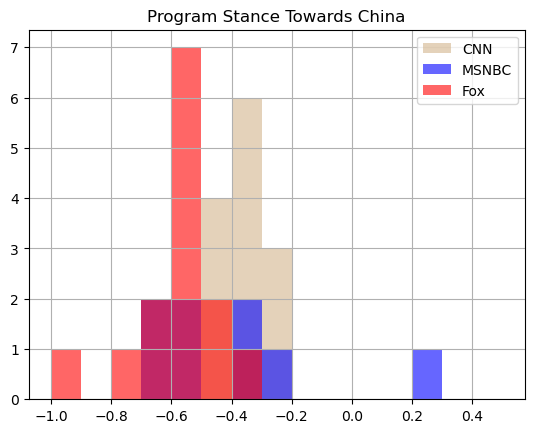

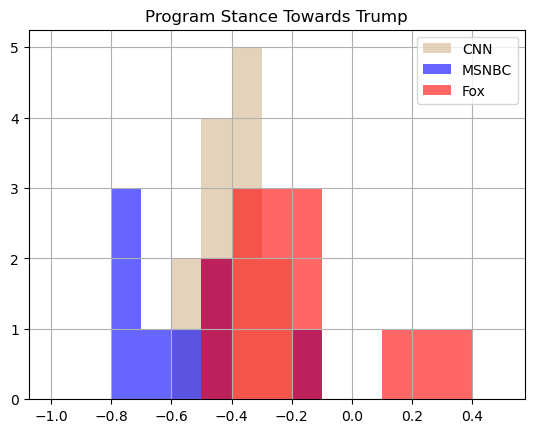

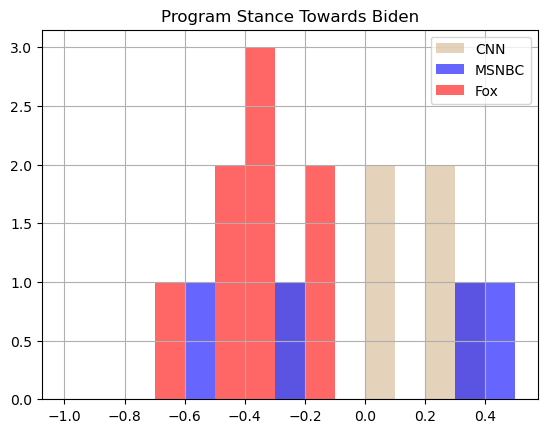

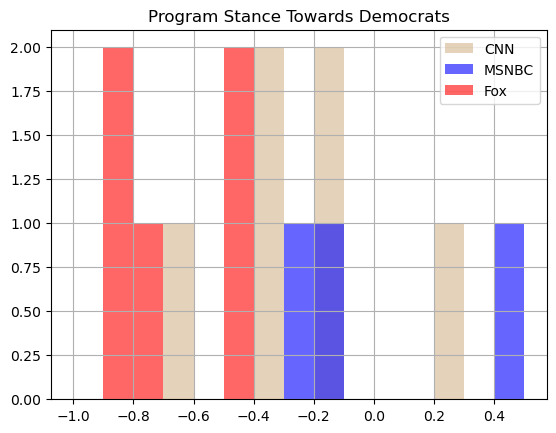

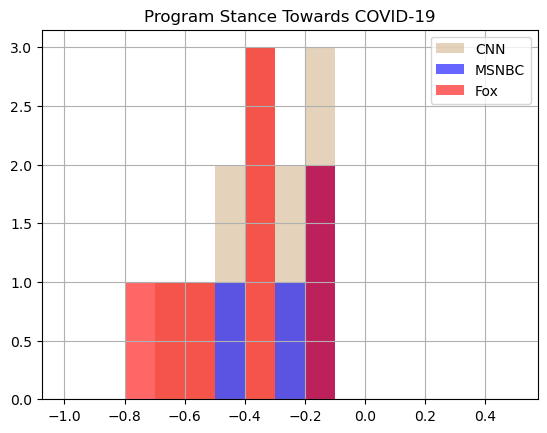

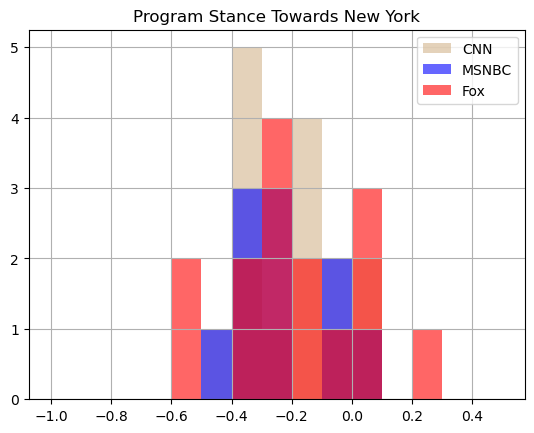

In [65]:
data = [cnn,msnbc,fox]
programs = ['CNN','MSNBC','Fox']
colors = ['tan','blue','Red']
words = ["China","Trump","Biden","Democrats","COVID-19","New York"]
for w in words:
    for i in range(len(data)):
        trdf = data[i]
        #print(trdf)
        #trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
        #trdf = trdf.explode('Topic').reset_index(drop=True)
        freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
        freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
        
        #keyword sentiment
        sent_df = trdf.pivot_table(index='Program', columns='Topic', values='avg_sentiment', aggfunc=np.mean, fill_value=0)
        #print(sent_df['Trump'])
        plt_df = sent_df.loc[sent_df[w] != 0]
        plt_df[w].hist(bins=[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5], color = colors[i], alpha = 0.6, label=programs[i])#0.8 - .2*i)
    plt.title("Program Stance Towards " + w)
    plt.legend()
    plt.show()


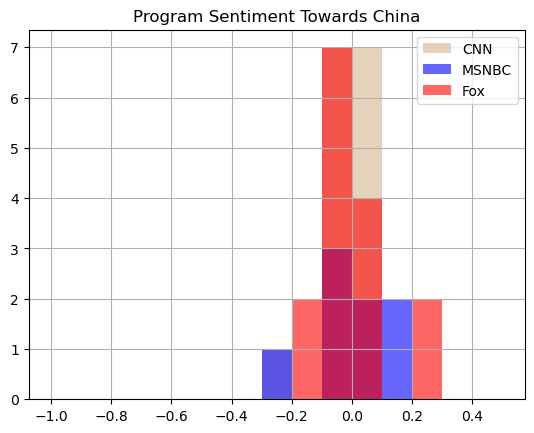

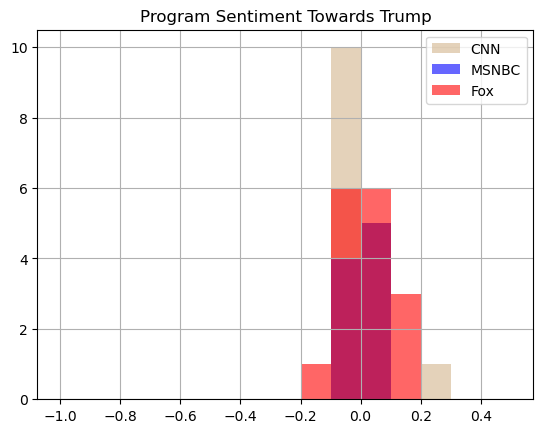

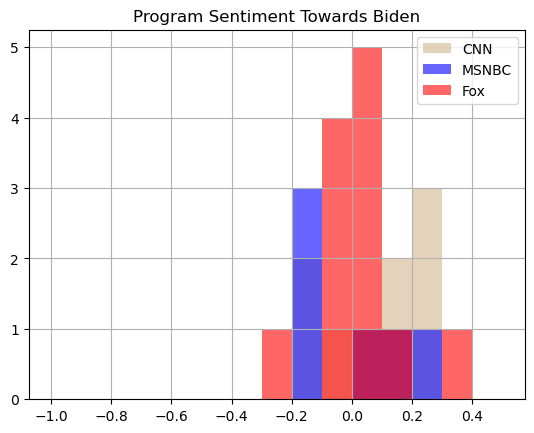

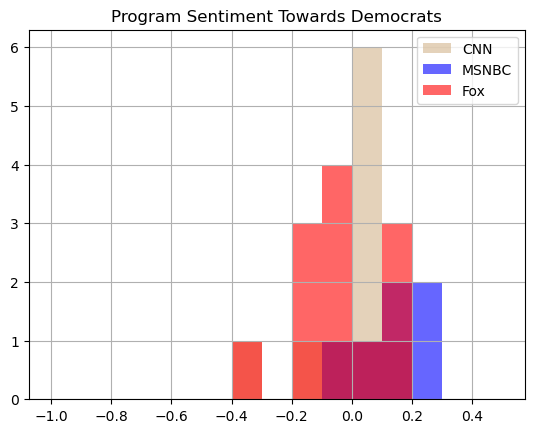

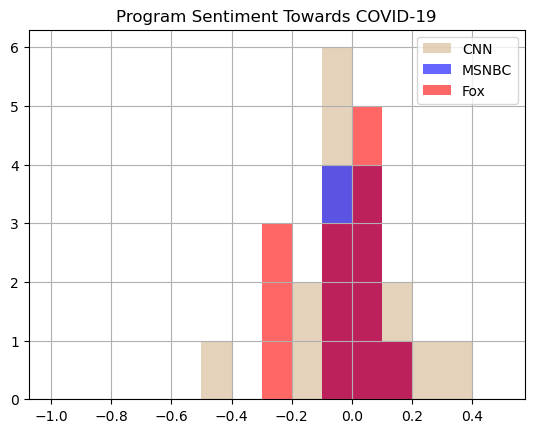

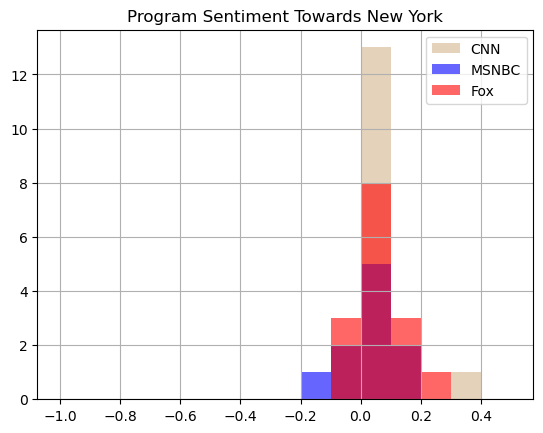

In [66]:
old_file = "../AY23 Runs/Outputs/new processed_transcripts_April2020.csv"
old_df = pd.read_csv(old_file)
old_df['Station'] = old_df['Program'].str.split().str[0]
programs = ['CNN','MSNBC','Fox']
for w in words:
    for i in range(len(data)):
        trdf = old_df[old_df['Station'] == programs[i]]
        #print(trdf)
        #trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
        #trdf = trdf.explode('Topic').reset_index(drop=True)
        freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
        freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
        
        #keyword sentiment
        sent_df = trdf.pivot_table(index='Program', columns='Topic', values='Sentiment', aggfunc=np.mean, fill_value=0)
        #print(sent_df['Trump'])
        plt_df = sent_df.loc[sent_df[w] != 0]
        plt_df[w].hist(bins=[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5], color = colors[i], alpha = 0.6, label=programs[i])#0.8 - .2*i)
    plt.title("Program Sentiment Towards " + w)
    plt.legend()
    plt.show()


## Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
colors = ['tan','Red','blue']
def get_clusters(trdf):
    #keyword frequency
    trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'avg_sentiment', aggfunc=len, fill_value=0)
    freq_df = freq_df.to_numpy()
    freq_df_2 = freq_df/freq_df.sum(axis=1)[:,None]
    freq_df_new = TfidfTransformer().fit_transform(freq_df_2).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='avg_sentiment', aggfunc=np.mean, fill_value=0)
    sent = sent_df.to_numpy()
    #for i in range(sent.shape[0]):
     #   for j in range(sent.shape[1]):
      #      if freq[i][j] < 2:
       #         sent[i][j] = 0
    

    #get program simmilarities by topic
    program_topic_network = cosine_similarity(freq_df_new)
    #program_topic_network = np.matmul(freq_df_new, freq_df_new.T)
    
    
    #get program simmilarity by sentiment
    progs = sent_df.index
    program_sent_network = np.array([])
    c = 0
    for p in range(len(progs)):
        sp = sent[p]
        psim = []
        for p1 in range(len(progs)):
            p_p1 = []
            freq_p = 0
            sp1 = sent[p1]
            for w in range(len(sp)):
                  if sp[w] != 0 and sp1[w] != 0:
                        p_p1.append(((2 - abs(sp[w] - sp1[w]) )/ 2) * (freq_df[p][w] * freq_df[p1][w]))
                        freq_p += freq_df[p][w] * freq_df[p1][w]
            if len(p_p1) > 0 and freq_p != 0:
                psim.append(sum(p_p1) /freq_p)
            else:
                psim.append(0)
                c += 1
        #print(psim)
        program_sent_network = np.append(program_sent_network, psim, axis=0)
    program_sent_network = (np.reshape(program_sent_network, [len(progs), len(progs)]) - program_sent_network.min()) / program_sent_network.max()
    print(program_sent_network)
    print(c)
    
    print(np.mean(program_topic_network))
    print(np.std(program_topic_network))
    print(np.mean(program_sent_network))
    print(np.std(program_sent_network))
    program_sim_network = np.multiply(program_topic_network, program_sent_network)
    #program_sim_network = program_topic_network + program_sent_network
    

    network_embedding = SpectralEmbedding(affinity='precomputed')
    """print(network_embedding)
    pos_program_embeddings = network_embedding.fit_transform(program_sent_network/program_sent_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Stance')
    plt.show()
    
    network_embedding = SpectralEmbedding(affinity='precomputed')
    print(network_embedding)
    pos_program_embeddings = network_embedding.fit_transform(program_topic_network/program_topic_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.xlabel('x position')
    plt.ylabel('y position')
    plt.title('Topic')
    plt.show()"""


    network_embedding = SpectralEmbedding(affinity='precomputed')
    print(network_embedding)
    pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network', palette = colors)
    plt.xlabel('x position')
    plt.ylabel('y position')
    #plt.title('Combined')
    plt.show()
    
    #clustering
    #clustering = KMeans(n_clusters=5).fit(program_sim_network)
    #clustering = AgglomerativeClustering(n_clusters = 3).fit(program_sim_network)
    #clustering = SpectralClustering(n_clusters = 3, affinity = 'precomputed').fit(program_sim_network)
    clustering = SpectralClustering(n_clusters = 3, affinity = 'nearest_neighbors').fit(pos_program_embeddings)

    clust_df = pd.DataFrame(list(zip(progs, list(clustering.labels_))),
               columns =['Program', 'Cluster'])
    return clust_df

C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.94882572 0.93258512 ... 0.96698053 0.95756625 0.97792358]
 [0.94882572 1.         0.93797866 ... 0.94658263 0.92795147 0.9403989 ]
 [0.93258512 0.93797866 1.         ... 0.91387559 0.87824053 0.92637625]
 ...
 [0.96698053 0.94658263 0.91387559 ... 1.         0.9797066  0.97588137]
 [0.95756625 0.92795147 0.87824053 ... 0.9797066  1.         0.96523796]
 [0.97792358 0.9403989  0.92637625 ... 0.97588137 0.96523796 1.        ]]
86
0.3696860357698082
0.22373535098585265
0.8937325921978121
0.16986930601679875
SpectralEmbedding(affinity='precomputed')


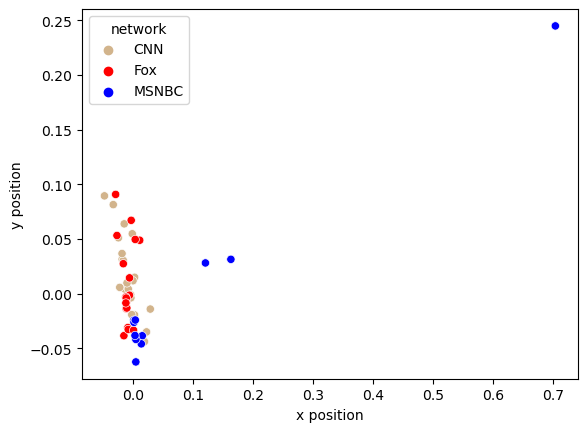

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.93188535 0.74707977 ... 0.92478392 0.92179394 0.9329347 ]
 [0.93188535 1.         0.93837053 ... 0.95840407 0.9246299  0.94162652]
 [0.74707977 0.93837053 1.         ... 0.87053571 0.93623306 0.88234677]
 ...
 [0.92478392 0.95840407 0.87053571 ... 1.         0.91358476 0.94526529]
 [0.92179394 0.9246299  0.93623306 ... 0.91358476 1.         0.93677102]
 [0.9329347  0.94162652 0.88234677 ... 0.94526529 0.93677102 1.        ]]
68
0.303419329800998
0.19037881454787098
0.8719656986272089
0.15766418343792707
SpectralEmbedding(affinity='precomputed')


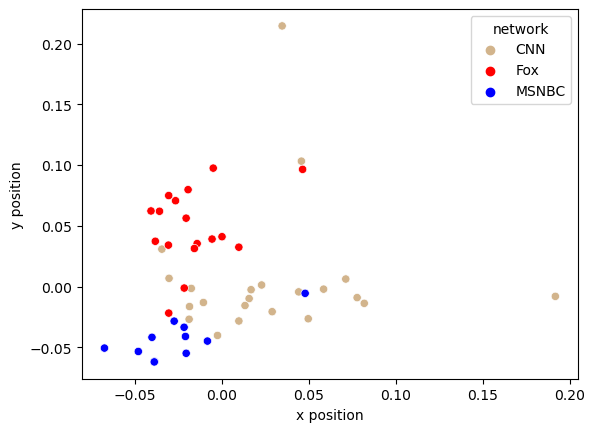

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.86991888 0.91604331 ... 0.91884527 0.93101264 0.93293423]
 [0.86991888 1.         0.88031591 ... 0.88038893 0.80871969 0.85633295]
 [0.91604331 0.88031591 1.         ... 0.92343027 0.92027558 0.95555443]
 ...
 [0.91884527 0.88038893 0.92343027 ... 1.         0.93887976 0.91891987]
 [0.93101264 0.80871969 0.92027558 ... 0.93887976 1.         0.9300029 ]
 [0.93293423 0.85633295 0.95555443 ... 0.91891987 0.9300029  1.        ]]
136
0.1890316428698957
0.16598040294859118
0.8336454989566217
0.21010399456602666
SpectralEmbedding(affinity='precomputed')


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


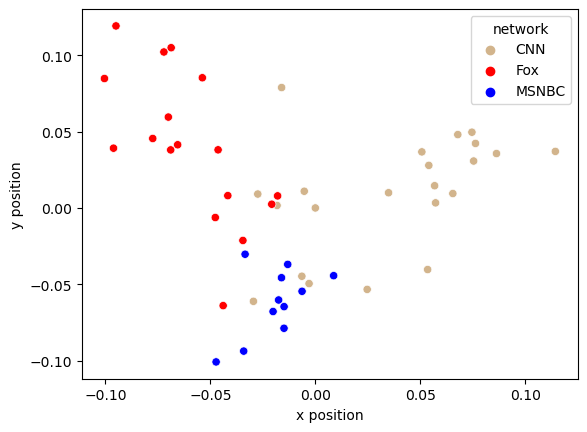

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.88047639 0.953942   ... 0.88968221 0.87395833 0.89530495]
 [0.88047639 1.         0.87164684 ... 0.91452789 0.8604363  0.79903307]
 [0.953942   0.87164684 1.         ... 0.83318712 0.93446393 0.94502803]
 ...
 [0.88968221 0.91452789 0.83318712 ... 1.         0.84579364 0.75266972]
 [0.87395833 0.8604363  0.93446393 ... 0.84579364 1.         0.9577335 ]
 [0.89530495 0.79903307 0.94502803 ... 0.75266972 0.9577335  1.        ]]
50
0.14428100611183964
0.16658671198341876
0.860687886120184
0.15005712489510634
SpectralEmbedding(affinity='precomputed')


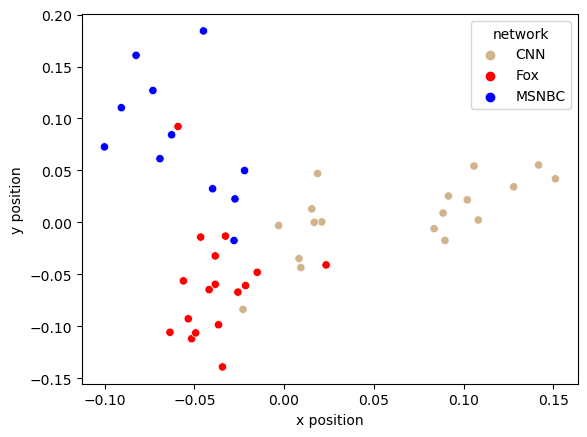

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.90339363 0.97392983 ... 0.95017512 0.95087435 0.92963024]
 [0.90339363 1.         0.89509683 ... 0.80691343 0.87732101 0.58220463]
 [0.97392983 0.89509683 1.         ... 0.85853081 0.91769475 0.90089179]
 ...
 [0.95017512 0.80691343 0.85853081 ... 1.         0.94751907 0.90831751]
 [0.95087435 0.87732101 0.91769475 ... 0.94751907 1.         0.90530514]
 [0.92963024 0.58220463 0.90089179 ... 0.90831751 0.90530514 1.        ]]
30
0.15137998856355428
0.16608322499132017
0.881152312117572
0.12622798302258637
SpectralEmbedding(affinity='precomputed')


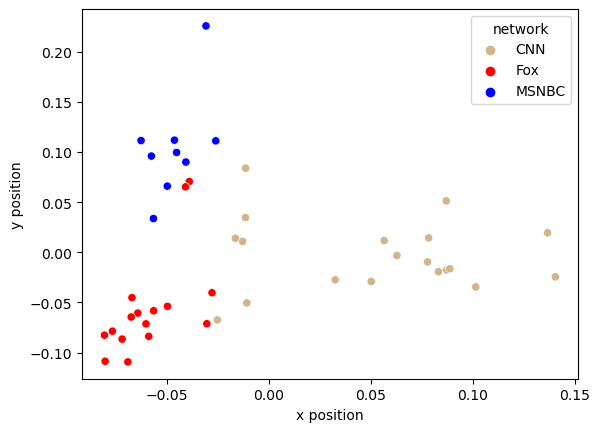

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.7        0.86737456 ... 0.94993013 0.92575506 0.93443134]
 [0.7        1.         0.         ... 0.         0.         0.        ]
 [0.86737456 0.         1.         ... 0.8882444  0.84816334 0.88984307]
 ...
 [0.94993013 0.         0.8882444  ... 1.         0.92950402 0.95094289]
 [0.92575506 0.         0.84816334 ... 0.92950402 1.         0.93378518]
 [0.93443134 0.         0.88984307 ... 0.95094289 0.93378518 1.        ]]
194
0.12440373310609065
0.15385202978526785
0.7977618736617592
0.23749105827960162
SpectralEmbedding(affinity='precomputed')


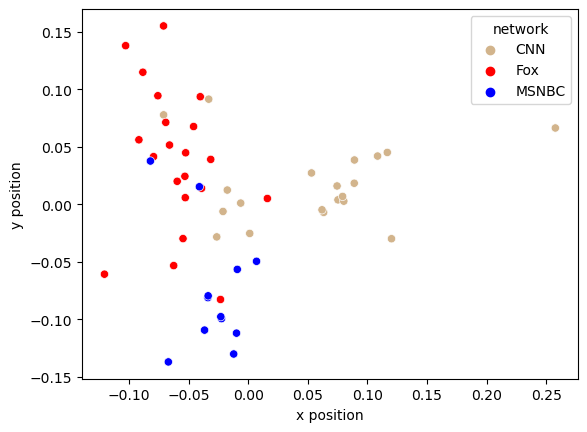

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.91620963 0.96335228 ... 0.89640295 0.96424983 0.93892236]
 [0.91620963 1.         0.88697428 ... 0.75287972 0.77042565 0.83775316]
 [0.96335228 0.88697428 1.         ... 0.90750361 0.96717333 0.94551032]
 ...
 [0.89640295 0.75287972 0.90750361 ... 1.         0.90646307 0.95346196]
 [0.96424983 0.77042565 0.96717333 ... 0.90646307 1.         0.93493912]
 [0.93892236 0.83775316 0.94551032 ... 0.95346196 0.93493912 1.        ]]
88
0.17031566825854758
0.16182114108351048
0.8152956882368413
0.18731758899025613
SpectralEmbedding(affinity='precomputed')


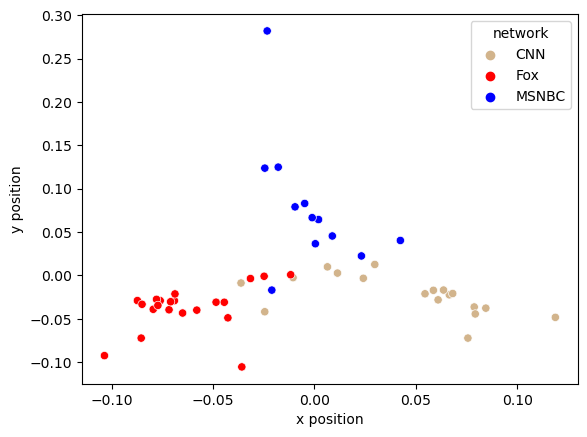

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.84215418 0.52232385 ... 0.96116445 0.86905072 0.94379936]
 [0.84215418 1.         0.84189815 ... 0.83796432 0.96693488 0.84948631]
 [0.52232385 0.84189815 1.         ... 0.49912761 0.70175113 0.56604603]
 ...
 [0.96116445 0.83796432 0.49912761 ... 1.         0.82805499 0.96699353]
 [0.86905072 0.96693488 0.70175113 ... 0.82805499 1.         0.82840286]
 [0.94379936 0.84948631 0.56604603 ... 0.96699353 0.82840286 1.        ]]
68
0.22652963171029997
0.17681844678884828
0.8131935315797989
0.16663179483623036
SpectralEmbedding(affinity='precomputed')


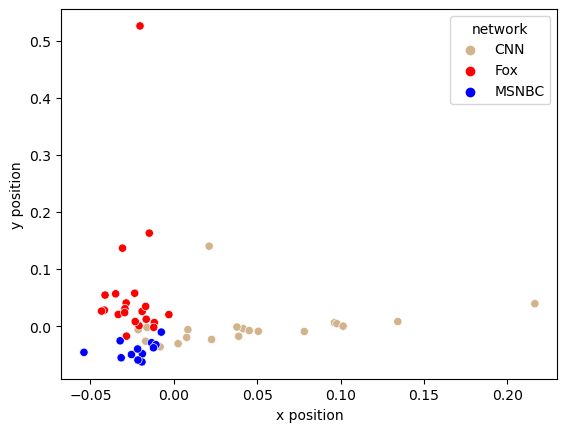

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.85046988 0.9177999  ... 0.94007427 0.8976547  0.89055514]
 [0.85046988 1.         0.8677597  ... 0.74164372 0.78763077 0.70395569]
 [0.9177999  0.8677597  1.         ... 0.86025301 0.83225275 0.84244531]
 ...
 [0.94007427 0.74164372 0.86025301 ... 1.         0.95559648 0.95780606]
 [0.8976547  0.78763077 0.83225275 ... 0.95559648 1.         0.98370749]
 [0.89055514 0.70395569 0.84244531 ... 0.95780606 0.98370749 1.        ]]
96
0.24185091577480589
0.1756094993499447
0.8185819129036158
0.1942730246193027
SpectralEmbedding(affinity='precomputed')


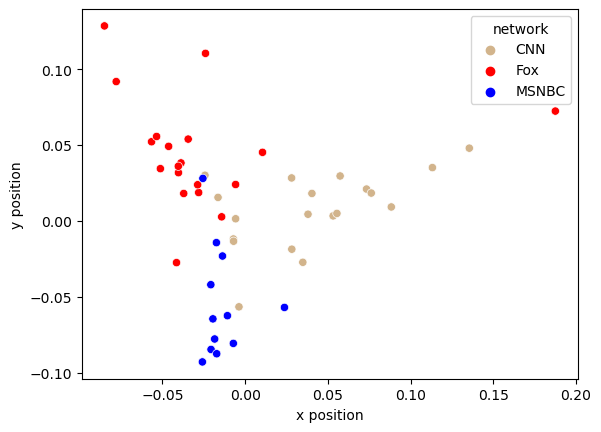

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.90700665 0.9673062  ... 0.92567014 0.92165512 0.88370288]
 [0.90700665 1.         0.92629675 ... 0.85942996 0.79056289 0.78896048]
 [0.9673062  0.92629675 1.         ... 0.88961143 0.92002863 0.86110824]
 ...
 [0.92567014 0.85942996 0.88961143 ... 1.         0.92223372 0.9795875 ]
 [0.92165512 0.79056289 0.92002863 ... 0.92223372 1.         0.93508294]
 [0.88370288 0.78896048 0.86110824 ... 0.9795875  0.93508294 1.        ]]
220
0.23672976505853577
0.16990532545984327
0.7755646534969657
0.24871433553178957
SpectralEmbedding(affinity='precomputed')


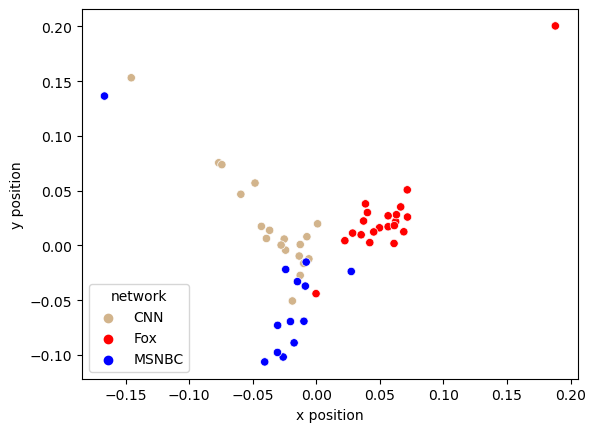

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.90786322 0.92520351 ... 0.94909567 0.93984749 0.94364306]
 [0.90786322 1.         0.91285876 ... 0.86832983 0.82334265 0.83054785]
 [0.92520351 0.91285876 1.         ... 0.89697974 0.8828462  0.86927047]
 ...
 [0.94909567 0.86832983 0.89697974 ... 1.         0.97859809 0.97141191]
 [0.93984749 0.82334265 0.8828462  ... 0.97859809 1.         0.96572464]
 [0.94364306 0.83054785 0.86927047 ... 0.97141191 0.96572464 1.        ]]
80
0.2803167878421081
0.18214568990853405
0.8378038050612511
0.167626735874733
SpectralEmbedding(affinity='precomputed')


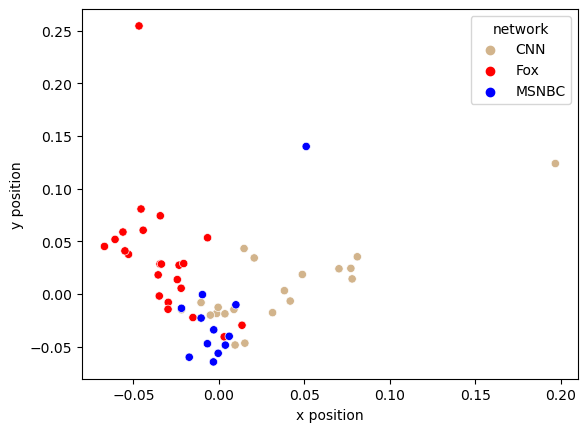

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_25632\258172742.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.78648402 0.91356277 ... 0.9576767  0.9312373  0.95197163]
 [0.78648402 1.         0.91725577 ... 0.59515653 0.91575399 0.55269269]
 [0.91356277 0.91725577 1.         ... 0.86931537 0.85156105 0.88997548]
 ...
 [0.9576767  0.59515653 0.86931537 ... 1.         0.93649896 0.96644729]
 [0.9312373  0.91575399 0.85156105 ... 0.93649896 1.         0.96646588]
 [0.95197163 0.55269269 0.88997548 ... 0.96644729 0.96646588 1.        ]]
242
0.2123509687441654
0.18420459490445187
0.7838496548431685
0.27221094979014304
SpectralEmbedding(affinity='precomputed')


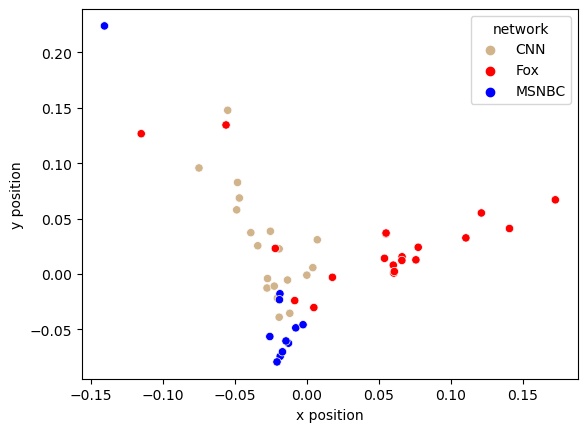

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
for i in range(12):#len(cnn_list)):
    cnn = pd.read_csv(cnn_list[i])
    msnbc = pd.read_csv(msnbc_list[i])
    fox = pd.read_csv(fox_list[i])
    trdf = cnn.append(msnbc)
    trdf = trdf.append(fox)
    trdf = trdf.dropna()
    clust_df = get_clusters(trdf)
    clust_df = clust_df.rename(columns={'Cluster': 'Cluster_' + str(i)})
    if i == 0:
        clusters_df = clust_df
    else:
        clusters_df = clusters_df.merge(clust_df, on = 'Program', how = 'left')
clusters_df.to_csv('clustersdf_embeddings.csv')
#clusters_df.to_csv('clustersdf_addition.csv')

C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_36232\3931944310.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_36232\3931944310.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


[[1.         0.88047639 0.953942   ... 0.88968221 0.87395833 0.89530495]
 [0.88047639 1.         0.87164684 ... 0.91452789 0.8604363  0.79903307]
 [0.953942   0.87164684 1.         ... 0.83318712 0.93446393 0.94502803]
 ...
 [0.88968221 0.91452789 0.83318712 ... 1.         0.84579364 0.75266972]
 [0.87395833 0.8604363  0.93446393 ... 0.84579364 1.         0.9577335 ]
 [0.89530495 0.79903307 0.94502803 ... 0.75266972 0.9577335  1.        ]]
50
0.14428100611183964
0.16658671198341876
0.860687886120184
0.15005712489510634
SpectralEmbedding(affinity='precomputed')


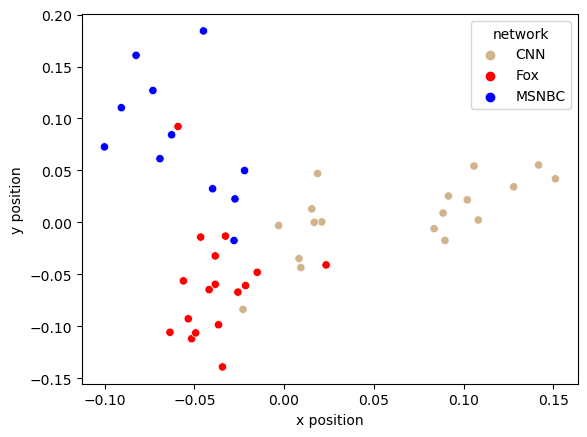

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [30]:
for i in [3]:#len(cnn_list)):
    cnn = pd.read_csv(cnn_list[i])
    msnbc = pd.read_csv(msnbc_list[i])
    fox = pd.read_csv(fox_list[i])
    trdf = cnn.append(msnbc)
    trdf = trdf.append(fox)
    trdf = trdf.dropna()
    clust_df = get_clusters(trdf)
    clust_df = clust_df.rename(columns={'Cluster': 'Cluster_' + str(i)})
    if i == 0:
        clusters_df = clust_df
    else:
        clusters_df = clusters_df.merge(clust_df, on = 'Program', how = 'left')
#clusters_df.to_csv('clustersdf.csv')
#clusters_df.to_csv('clustersdf_addition.csv')


In [31]:
print(sent_df.shape)

(17, 209)


In [51]:
for i in [3]:#len(cnn_list)):
    cnn = pd.read_csv(cnn_list[i])
    msnbc = pd.read_csv(msnbc_list[i])
    fox = pd.read_csv(fox_list[i])
    trdf = cnn.append(msnbc)
    trdf = trdf.append(fox)
    trdf = trdf.dropna()
#keyword frequency
trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
trdf = trdf.explode('Topic').reset_index(drop=True)

#keyword sentiment
sent_df = trdf.pivot_table(index='Program', columns='Topic', values='avg_sentiment', aggfunc=np.mean, fill_value=0)
sent_df[['CDC','China','COVID-19','Fauci','House','New York','Trump']].iloc[[0,3,27,28,41,43],:]



C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_36232\1724675660.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = cnn.append(msnbc)
C:\Users\Seth Benson\AppData\Local\Temp\ipykernel_36232\1724675660.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trdf = trdf.append(fox)


Topic,CDC,China,COVID-19,Fauci,House,New York,Trump
Program,,,,,,,
CNN ANDERSON COOPER 360 DEGREES,0.000000,-0.315758,-0.500000,-0.083333,0.000000,-0.011438,-0.171429
CNN CNN NEWSROOM,-0.423148,-0.373332,-0.354845,0.034750,-0.120833,-0.185285,-0.353463
Fox News Network SUNDAY MORNING FUTURES,0.000000,-0.541566,0.000000,0.000000,0.000000,-0.533333,0.294118
Fox News Network THE FIVE,0.100000,-0.500231,0.000000,-0.176471,0.000000,0.027778,-0.363217
MSNBC MTP DAILY,-0.025000,0.250000,0.000000,-0.200000,0.000000,-0.089304,-0.155952
MSNBC THE BEAT WITH ARI MELBER,0.000000,-0.551196,-0.250000,-0.071429,0.000000,0.056643,-0.512698


In [52]:
freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'avg_sentiment', aggfunc=len, fill_value=0)
freq_df[['CDC','China','COVID-19','Fauci','House','New York','Trump']].iloc[[0,3,27,28,41,43],:]

Topic,CDC,China,COVID-19,Fauci,House,New York,Trump
Program,,,,,,,
CNN ANDERSON COOPER 360 DEGREES,0,5,1,2,0,3,2
CNN CNN NEWSROOM,36,105,72,22,4,167,100
Fox News Network SUNDAY MORNING FUTURES,0,3,0,0,0,1,1
Fox News Network THE FIVE,1,9,0,1,0,2,17
MSNBC MTP DAILY,2,1,0,1,0,9,4
MSNBC THE BEAT WITH ARI MELBER,0,4,1,2,0,6,3
